In [19]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import scipy.io
import tqdm

In [13]:
Phi, y = load_svmlight_file('data/cod-rna')
Phi.shape, y.shape

((59535, 8), (59535,))

In [22]:
# y = y.reshape(-1, 1)
# y = csr_matrix(y)
# y.shape

(59535, 1)

In [14]:
N, n = Phi.shape

In [257]:
# alpha policies
def alpha_standard(k):
    return 2 / (k + 2)

def alpha_icml(k, Gap, hess, s, x):
    e = hess.dot((s - x).T).T.dot((s - x).T) ** 0.5
    t = Gap / (e * (Gap + e))
    beta = alpha_standard(k)
    return min(beta, t)

# Logistic regression

In [266]:
def logistic_loss(Phi, y, x, mu):
    """
        Phi -- N x n
        y -- N x 1
        x -- 1 x n
        mu -- 1 x 1
    """
    dot_product = Phi * x # N x 1
    return np.log(1 + np.exp(-y * (dot_product + mu))) # N x 1

def mean_empirical_risk(Phi, y, x, mu, gamma):
    """
        1 / N \sum_{i = 1}^N logreg(y * (<Phi, x> + mu)) + gamma / 2 * x^Tx
        Phi -- N x n
        y -- N x 1
        x -- 1 x n
        mu -- 1 x 1
        gamma -- const
    """
    ll = logistic_loss(Phi, y, x, mu) # N x 1
    return np.mean(ll) + gamma / 2 * x.dot(x.T) # 1 x 1

def grad_mean_empirical_risk(Phi, y, x, mu, gamma):
    """
        1 / N \sum_{i = 1}^N -y * Phi / (exp(y * (<Phi, x> + mu)) + 1) + gamma * x
        Phi -- N x n
        y -- N x 1
        x -- 1 x n
        mu -- 1 x 1
        gamma -- const
    """
    numer = -Phi.multiply(y.reshape(-1, 1)) # N x n
    dot_product = Phi * x # N x 1
    denom = (np.exp(y * dot_product + mu) + 1).reshape(-1, 1) # N x 1
    return np.mean(numer / denom.reshape(-1, 1), axis=0) + gamma * x # 1 x n

def hess_mean_empirical_risk(Phi, y, x, mu, gamma):
    """
        1 / N \sum_{i = 1}^N phi_i.T.dot(phi_i) * exp(y * (<Phi, x> + mu)) / (1 + exp(...))^2 + gamma
        Phi -- N x n
        y -- N x 1
        x -- 1 x n
        mu -- 1 x 1
        gamma -- const
    """
    dot_product = Phi * x # N x 1
    exp_product = np.exp(y * (dot_product + mu)) # N x 1
    denom = np.power((1 + exp_product), 2)
#     Phi = Phi.todense()
#     dot_product = dot_product.todense()
#     for i in range(Phi.shape[0]):
#         matrices.append(Phi[0].T.dot(Phi[0]) * exp_product[i, 0] / denom[i, 0]) #  n x n (N times)
#     return np.mean(matrices, axis=0) + gamma
    super_Phi = np.einsum('ij,ik->ijk', Phi.toarray(), Phi.toarray())
    numer = super_Phi * exp_product.reshape(-1, 1, 1)
    return np.mean(numer / denom.reshape(-1, 1, 1), axis=0)

def frank_wolfe_log_reg(Phi, 
                        y,
                        x_0=np.zeros(n),
                        mu=0, 
                        gamma=0.01, 
                        alpha_policy='standard',
                        eps=0.001, 
                        R=1,
                        print_every=10):
    """
        Phi -- object matrix (N x n)
        y -- class label (N x 1)
        x_0 -- starting point (1 x n)
        mu -- bias (1 x 1) == 0
        gamma -- regularization coefficient
        alpha_policy -- name of alpha changing policy function
        eps -- epsilon
        R -- l_1 ball radius
        print_every -- print results every print_every steps
    """
    x = x_0
    alpha = 1
    alpha_hist = []
    Gap_hist = []
    Q_hist = []
    print('********* Algorithm starts *********')
    for k in range(1, 501):
        Q = mean_empirical_risk(Phi, y, x, mu, gamma)

        grad_f = grad_mean_empirical_risk(Phi, y, x, mu, gamma) # 1 x n
        
        i_max = np.argmax(np.abs(grad_f))
        s = np.zeros(n)
        s[i_max] = np.sign(-grad_f[0, i_max]) # 1 x n
        Gap = grad_f.dot((x - s).T)[0, 0]
        
        # filling history
        alpha_hist.append(alpha)
        Gap_hist.append(Gap)
        Q_hist.append(Q)
        
        if Gap > eps:
            if alpha_policy == 'standard':
                alpha = alpha_standard(k)
            elif alpha_policy == 'icml':
                hessian = hess_mean_empirical_risk(Phi, y, x, mu, gamma)
                alpha = alpha_icml(k, Gap, hessian, s, x)
            x = x + alpha * (s - x)
        else:
            print('Convergence achieved!')
            print(f'iter = {k}, stepsize = {alpha}, Gap = {Gap}')
            break
            
        if k % print_every == 0 or k == 1:
            print(f'iter = {k}, stepsize = {alpha}, Gap = {Gap}, Q={Q}')
    return x, alpha_hist, Gap_hist, Q_hist

In [179]:
lam = np.max(np.sqrt(np.sum(W.power(2), axis=1)))**2 / (4 * n)

In [253]:
mean_empirical_risk(Phi, y, np.zeros(n), 0, lam)

0.6931471805599453

In [267]:
x, st_alpha_hist, st_Gap_hist, st_Q_hist = frank_wolfe_log_reg(Phi, y, gamma=lam)

********* Algorithm starts *********
iter = 1, stepsize = 0.6666666666666666, Gap = 30.26095574032082, Q=0.6931471805599453


/home/twlvth/.pyenv/versions/wiki_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/twlvth/.pyenv/versions/wiki_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


iter = 10, stepsize = 0.16666666666666666, Gap = 224.39898556606488, Q=21.986112035919156
iter = 20, stepsize = 0.09090909090909091, Gap = 212.01375878068694, Q=10.536324501564618
iter = 30, stepsize = 0.0625, Gap = 208.02320238982853, Q=6.918566065210213
iter = 40, stepsize = 0.047619047619047616, Gap = 205.90148149910908, Q=5.150392260921868
iter = 50, stepsize = 0.038461538461538464, Gap = 204.35762542186347, Q=4.103993921807554
iter = 60, stepsize = 0.03225806451612903, Gap = 202.92614863759906, Q=3.4136947708473224
iter = 70, stepsize = 0.027777777777777776, Gap = 201.38788146995915, Q=2.9253498541189162
iter = 80, stepsize = 0.024390243902439025, Gap = 199.63204688965274, Q=2.562706144793729
iter = 90, stepsize = 0.021739130434782608, Gap = 197.60833221044575, Q=2.283687746361442
iter = 100, stepsize = 0.0196078431372549, Gap = 195.30375575806758, Q=2.063146889903391
iter = 110, stepsize = 0.017857142857142856, Gap = 192.72864685111927, Q=1.8851063976418163
iter = 120, stepsize =

In [258]:
x, icml_alpha_hist, icml_Gap_hist, icml_Q_hist = frank_wolfe_log_reg(Phi, y, eps=0.01, alpha_policy='icml', gamma=lam)

********* Algorithm starts *********
iter = 1, stepsize = 0.00043295770276118126, Gap = 30.26095574032082, Q=0.6931471805599453
iter = 10, stepsize = 0.0026376774688627834, Gap = 6.963286859447625, Q=0.5728959714020916
iter = 20, stepsize = 0.002092650184149595, Gap = 4.92677740219306, Q=0.4954534555542991
iter = 30, stepsize = 0.001708974135922036, Gap = 3.607208325503444, Q=0.4510622676418635
iter = 40, stepsize = 0.0014091926886904077, Gap = 2.7044308340620833, Q=0.424391306172671
iter = 50, stepsize = 0.0011638825248153776, Gap = 2.061826596102098, Q=0.4079336018763829
iter = 60, stepsize = 0.0009595938984792936, Gap = 1.5910702156192778, Q=0.3976167536262324
iter = 70, stepsize = 0.0007887354178984425, Gap = 1.2387873137710956, Q=0.39108732946162583
iter = 80, stepsize = 0.0006460766589406945, Gap = 0.9709314946319112, Q=0.3869306207981837
iter = 90, stepsize = 0.0005274567942218942, Gap = 0.7648103530514097, Q=0.3842748290915394
iter = 100, stepsize = 0.0004293090113698486, Gap =

In [259]:
with open('./concord_points.pckl', 'rb') as f:
    concord_points = pickle.load(f)
    
with open('./AGD_points.pckl', 'rb') as f:
    AGD_points = pickle.load(f)

In [198]:
W = Phi
n = Phi.shape[0]
p = Phi.shape[1]

bias = 0

def fn_logis_Val(y, W, bias, x, lam, topv=None):
    
    if topv is None:
        topv = np.exp(-y * (W * x + bias))
    Valv = np.log(1 + topv)
#     print(Valv.shape)
    Val1 = np.sum(Valv) / n
    Val2 = 0.5 * lam * (np.dot(x, x))
    Val = Val1 + Val2
    return Val

In [260]:
mean_empirical_risk(Phi, y, AGD_points[0], bias, lam)

0.6931471805599453

In [261]:
fn_logis_Val(y, W, bias, AGD_points[0], lam)

(59535,)


5158.314674329543

In [178]:
len(icml_Q_hist)

498

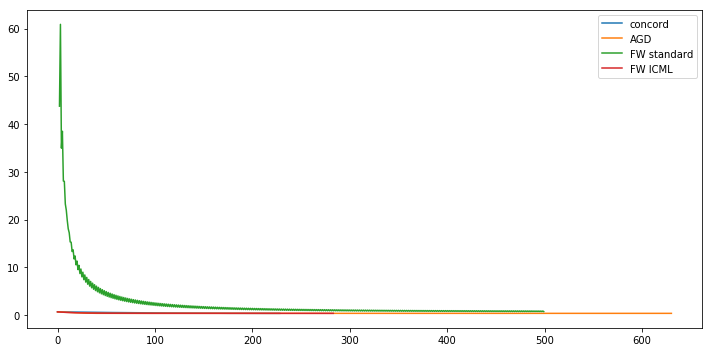

In [284]:
plt.figure(figsize=(10, 5))
plt.plot([mean_empirical_risk(Phi, y, point, 0, lam) for point in concord_points], label='concord')
plt.plot([mean_empirical_risk(Phi, y, point, 0, lam) for point in AGD_points], label='AGD')
plt.plot(st_Q_hist, label='FW standard')
plt.plot(icml_Q_hist, label='FW ICML')
plt.legend()
plt.tight_layout()
plt.show()

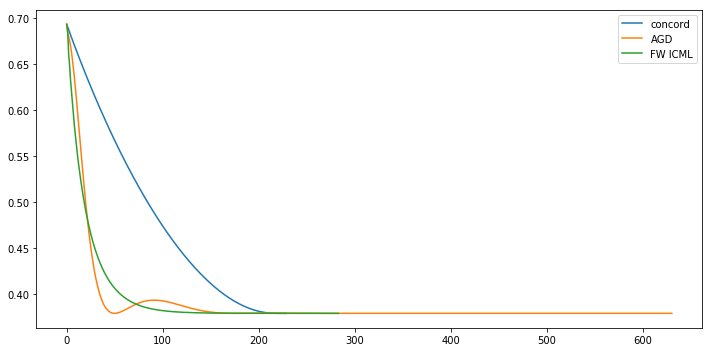

In [285]:
plt.figure(figsize=(10, 5))
plt.plot([mean_empirical_risk(Phi, y, point, 0, lam) for point in concord_points], label='concord')
plt.plot([mean_empirical_risk(Phi, y, point, 0, lam) for point in AGD_points], label='AGD')
# plt.plot(st_Q_hist, label='FW standard')
plt.plot(icml_Q_hist, label='FW ICML')
plt.legend()
plt.tight_layout()
plt.show()